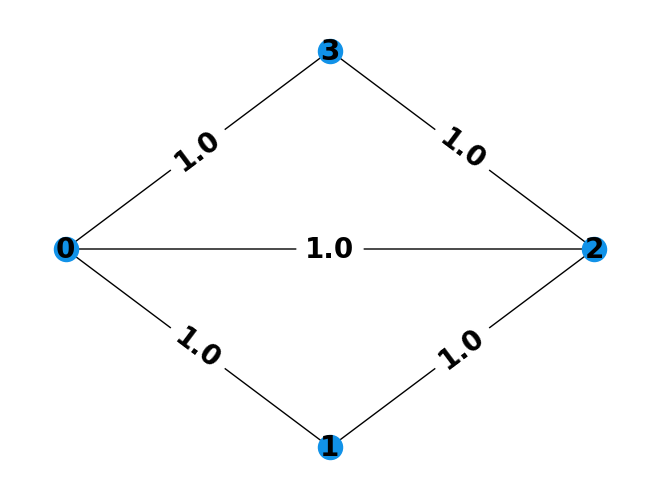

In [8]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
edges = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(3,2,1.0),(1,2,1.0)]
G.add_edges_from(edges)
mpl_draw(G, pos=rx.shell_layout(G),with_labels=True,edge_color='black',
         edge_labels=str,node_color='#1192E8',node_size=300,
         font_size=20,font_weight='bold')

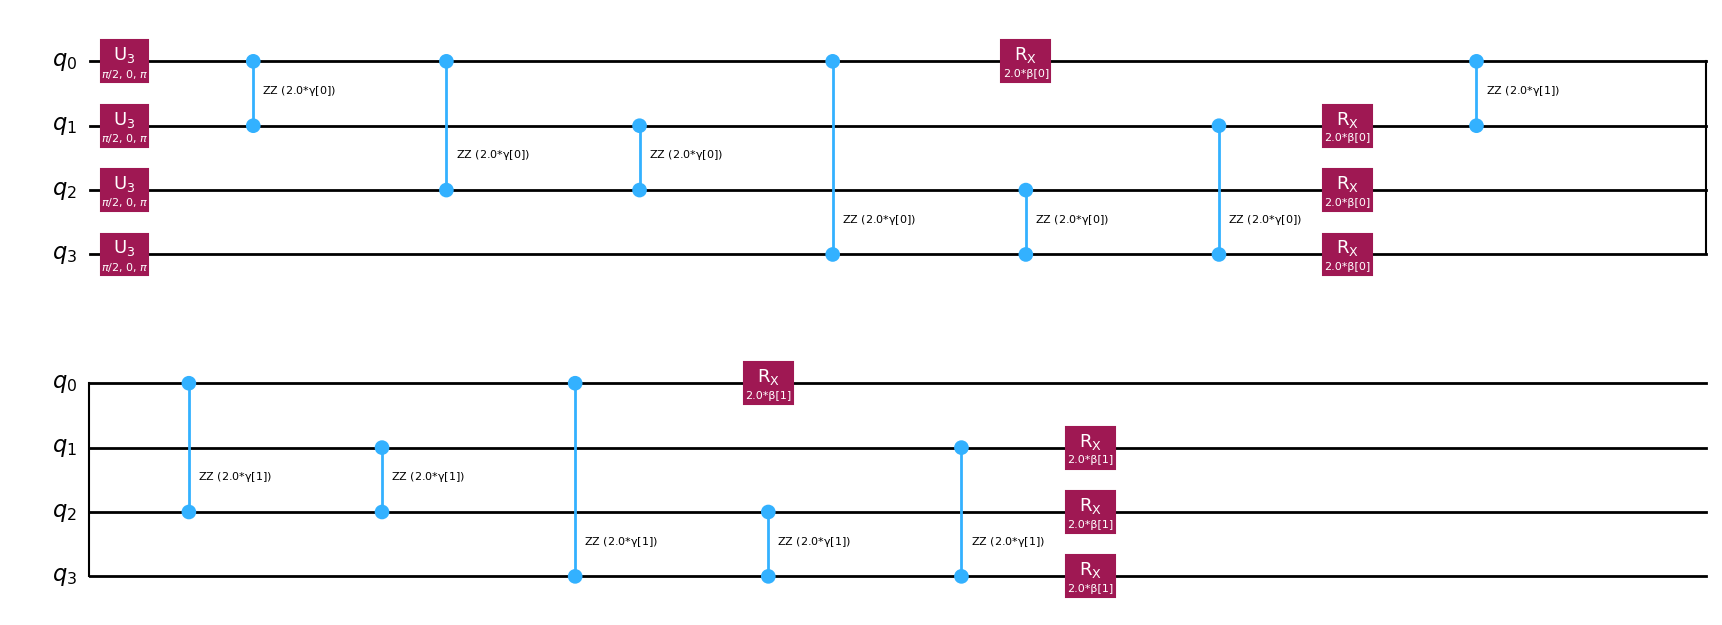

In [14]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

max_hamiltonian = SparsePauliOp.from_list(
    [
        ("IIZZ" , 1),("IZIZ" , 1),("IZZI" , 1),("ZIIZ" , 1),("ZZII" , 1),("ZIZI" , 1)
    ]
)
max_ansatz = QAOAAnsatz(max_hamiltonian,reps=2)
max_ansatz.decompose(reps=3).draw('mpl')

In [20]:
offset = -sum(edge[2] for edge in edges)/2
print(f"""OFFSET:{offset}""")

OFFSET:-2.5


In [37]:
def cost_func(params, ansatz,hamiltonian,estimator):
  pub = (ansatz, hamiltonian, params)
  #cost = estimator.run([pub]).result()[0].evs
  cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
  return cost

In [31]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

# Add your token below
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

/var/folders/ys/tg4mzr093dsgjjl04f5n863c0000gn/T/ipykernel_21393/2660419041.py:14: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(session=session)
/var/folders/ys/tg4mzr093dsgjjl04f5n863c0000gn/T/ipykernel_21393/2660419041.py:15: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)


In [29]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(max_ansatz.num_parameters)
print(x0)

[0.52964901 4.66951577 3.59589851 0.56988918]


In [38]:
result = minimize(cost_func, x0, args=(max_ansatz, max_hamiltonian, estimator), method="COBYLA")

IBMInputValueError: 'The instruction QAOA on qubits (0, 1, 2, 3) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'

In [40]:
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
import math

psi1 = Statevector([math.cos(math.pi / 8), math.sin(math.pi / 8)])
psi2 = Statevector([math.cos(5 * math.pi / 8) , math.sin(5 * math.pi / 8)])

H = Operator(psi1) - Operator(psi2)
display(array_to_latex(H))

<IPython.core.display.Latex object>

In [2]:
import networkx as nx
import numpy as np
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit import qasm3

n = 4
#G = nx.Graph()
print(np.arange(0, n, 1))
w = np.array([[0.0, 1.0, 1.0, 1.0],[1.0, 0.0, 1.0, 0.0],[1.0, 1.0, 0.0, 1.0],[1.0,0.0,1.0,0.0]])
G = nx.from_numpy_array(w)
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
#G.add_weighted_edges_from(elist)
colors = ["r" for nodes in G.nodes]
print(colors)
pos = nx.spring_layout(G)
def draw_graph(G, colors, pos):
    nx.draw_networkx(G, node_color = colors, pos = pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    print("x{"+str(x)+"}")
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

qubitOp, offset = qp.to_ising()
print("Ising Hamiltonian:" + str(qubitOp))

from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler

optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=3, entanglement="linear")
sampler = Sampler()
qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=3)
result = qaoa.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("best measurement:", result.best_measurement)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution: ", x)

print("qasm3.0:", qasm3.dumps(qaoa.ansatz, experimental=qasm3.ExperimentalFeatures.SWITCH_CASE_V1))











[0 1 2 3]
['r', 'r', 'r', 'r']
x{[0, 0, 0, 0]}
case = [0, 0, 0, 0] cost = 0.0
x{[1, 0, 0, 0]}
case = [1, 0, 0, 0] cost = 3.0
x{[0, 1, 0, 0]}
case = [0, 1, 0, 0] cost = 2.0
x{[1, 1, 0, 0]}
case = [1, 1, 0, 0] cost = 3.0
x{[0, 0, 1, 0]}
case = [0, 0, 1, 0] cost = 3.0
x{[1, 0, 1, 0]}
case = [1, 0, 1, 0] cost = 4.0
x{[0, 1, 1, 0]}
case = [0, 1, 1, 0] cost = 3.0
x{[1, 1, 1, 0]}
case = [1, 1, 1, 0] cost = 2.0
x{[0, 0, 0, 1]}
case = [0, 0, 0, 1] cost = 2.0
x{[1, 0, 0, 1]}
case = [1, 0, 0, 1] cost = 3.0
x{[0, 1, 0, 1]}
case = [0, 1, 0, 1] cost = 4.0
x{[1, 1, 0, 1]}
case = [1, 1, 0, 1] cost = 3.0
x{[0, 0, 1, 1]}
case = [0, 0, 1, 1] cost = 3.0
x{[1, 0, 1, 1]}
case = [1, 0, 1, 1] cost = 2.0
x{[0, 1, 1, 1]}
case = [0, 1, 1, 1] cost = 3.0
x{[1, 1, 1, 1]}
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0
Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables 

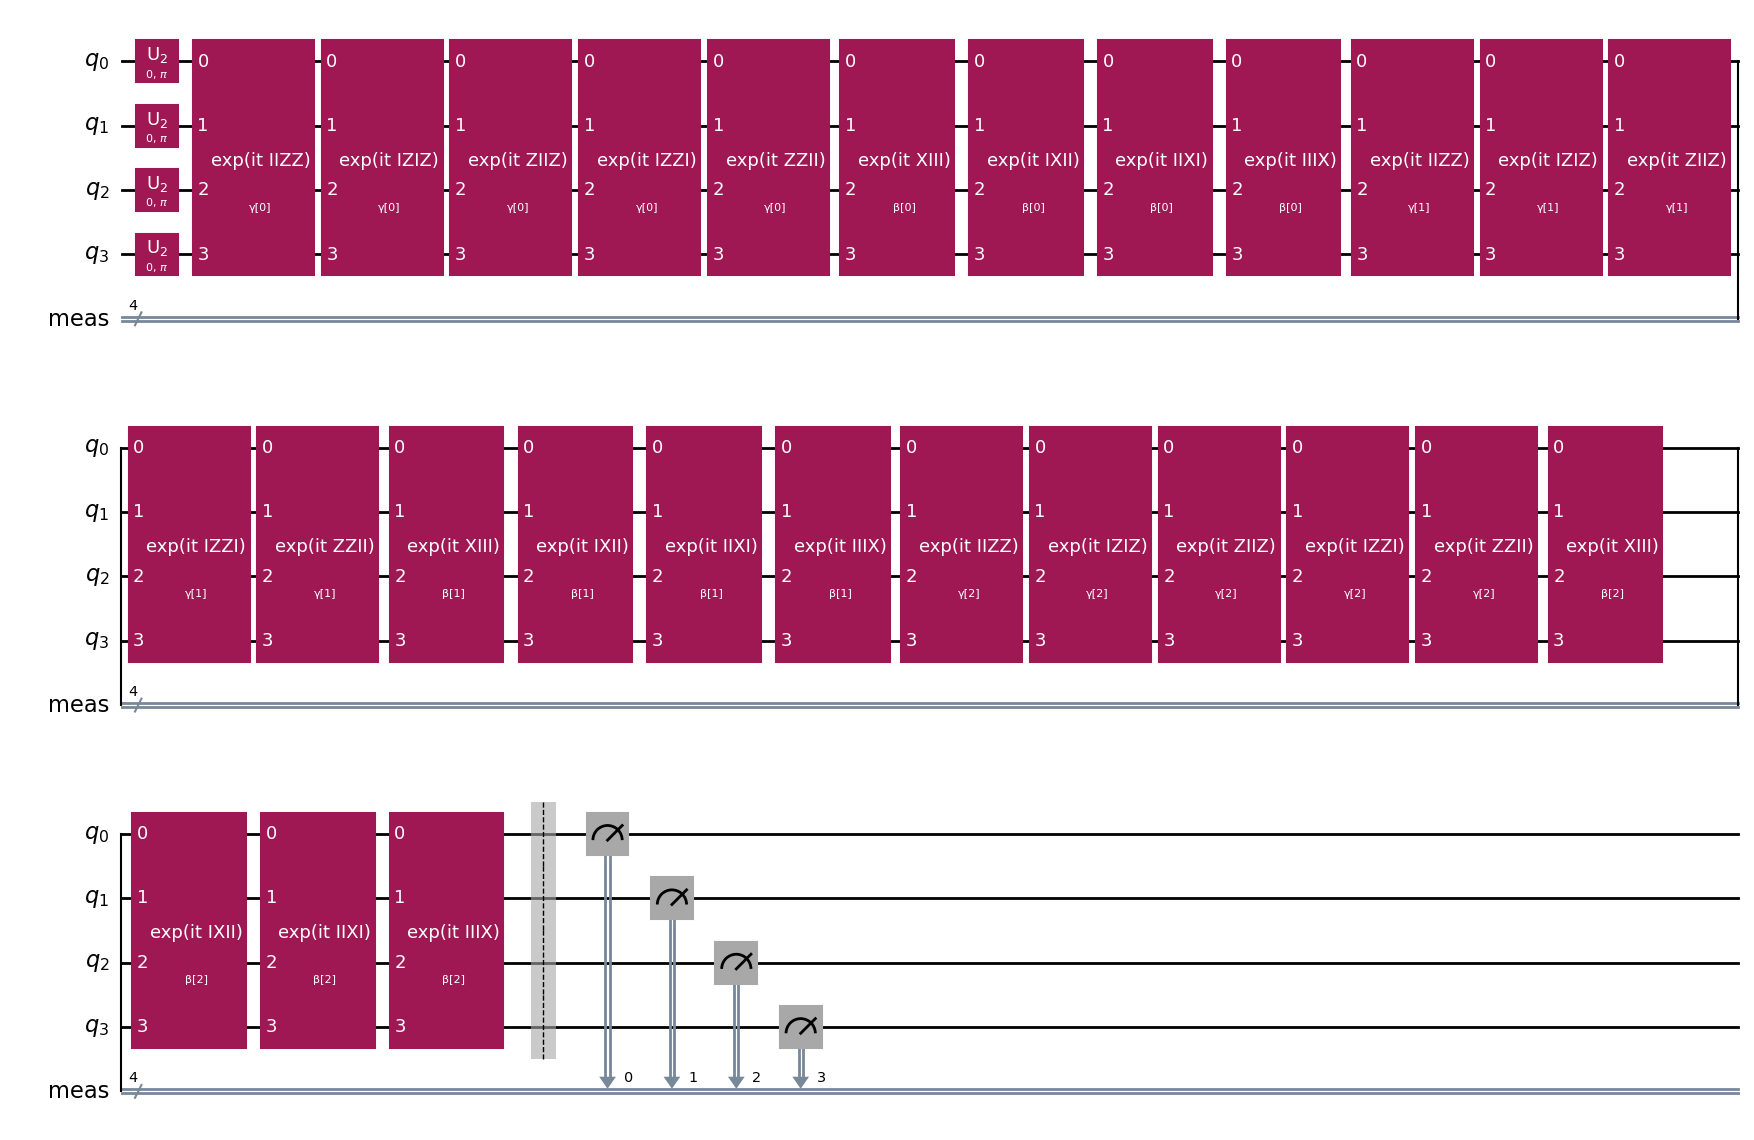

In [3]:
import numpy as np
qaoa.ansatz.decompose().draw("mpl")

In [6]:
import urllib.request

# Download the GSET file
url = 'https://web.stanford.edu/~yyye/yyye/Gset/'
file_path = 'G1.txt'
G = urllib.request.urlretrieve(url, file_path)


[(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
SparsePauliOp(['IIIZZ', 'IIZIZ', 'IIZZI', 'IZIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


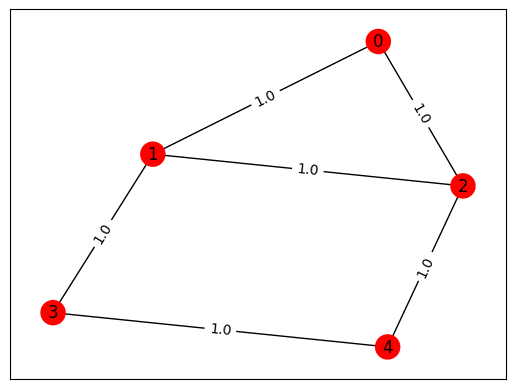

In [28]:
import networkx as nx
import urllib.request
import networkx as nx
import numpy as np
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit import qasm3
from qiskit_algorithms.utils import algorithm_globals

def create_graph_from_edges(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    return G


def read_gset_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    num_nodes, num_edges = map(int, lines[0].split())
    elist = []
    for line in lines[1:]:
        if line.strip():
            u, v, weight = map(int, line.split())
            elist.append((u - 1, v - 1, float(weight)))  # Convert to 0-based index and float weight
    return elist, num_nodes, num_edges

def draw_graph(G, colors, pos):
    nx.draw_networkx(G, node_color=colors,pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def get_weight_matrix(G, n):
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
    return w

    
# URL of the GSET file
url = 'https://web.stanford.edu/~yyye/yyye/Gset/G1'
file_path = '/Users/mac/workspace/quantum-journey2/classical_to_quantum/graph_cases/G1'
# Read the GSET file
elist, num_nodes, num_edges = read_gset_file(file_path)
print(elist)

# Create the NetworkX graph
G = nx.Graph()
G.add_weighted_edges_from(elist)
w = get_weight_matrix(G, num_nodes)
#print(w)

colors = ["r" for nodes in G.nodes]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()

qubitOp, offset = qp.to_ising()
print(str(qubitOp))

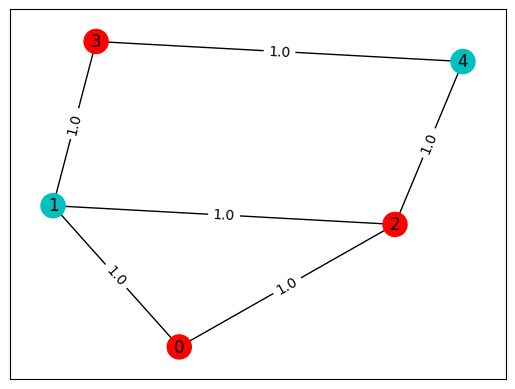

In [26]:
optimizer = SPSA(maxiter=300)
sampler = Sampler()
qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=3)
result = qaoa.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
colors = ["r" if x[i] == 00 else "c" for i in range(num_nodes)]
draw_graph(G, colors, pos)

In [20]:
import os 
os.getcwd()

'/Users/mac/workspace/quantum-journey2/old-before-JUNE/qiskit'

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


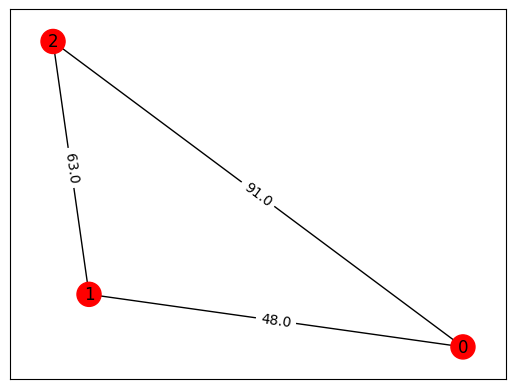

In [35]:
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [42]:
from itertools import permutations

def brute_force_tsp(w, N):
    a = list(permutations(range(1,N)))
    last_best_distance = np.inf
    for i in a:
        distance  = 0
        pre_j = 0
        for j in i:
            distance = distance + w[pre_j,j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = "+str(order) + "Distance = " + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

order = (0, 1, 2)Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


In [44]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [45]:
qubitOp = qp.to_ising()


QiskitOptimizationError: 'There must be no constraint in the problem. You can use `QuadraticProgramToQubo` converter to convert constraints to penalty terms of the objective function.'

In [1]:
from qiskit_optimization.applications.clique import Clique

In [7]:
from classical_to_quantum.applications.graph.gset import *
from qiskit import qasm3
from classical_to_quantum.applications.graph.graph_problem import Graph
from qiskit_optimization.applications.clique import Clique
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
import numpy as np

from qiskit.circuit.library import TwoLocal

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]





In [8]:
converge_counts = np.empty([len(optimizers)], dtype=object)
print(converge_counts)

[None None None]


Optimizer: COBYLA        -2.7157524292680844
[1 1 1 0]
Optimizer: L_BFGS_B        -2.531431711988811
[1 0 1 0]
Optimizer: SLSQP        -2.9229392220904304
[1 1 1 0]
Optimization complete      
[1. 1. 1. 0.]
-3.5


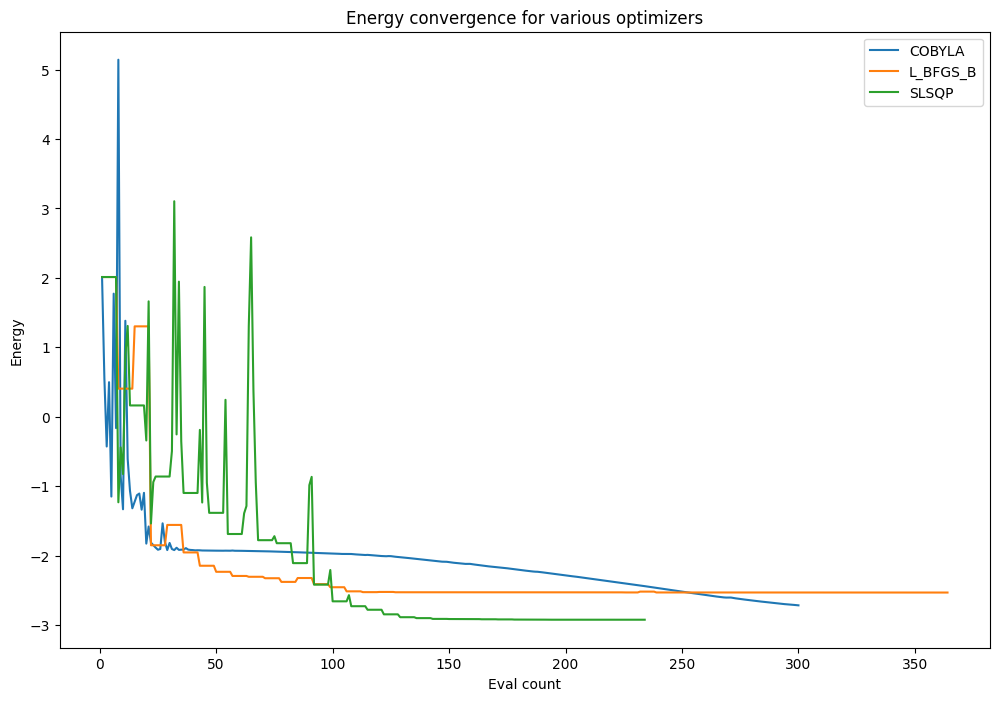

In [28]:
from classical_to_quantum.applications.graph.gset import *
from qiskit import qasm3
from classical_to_quantum.applications.graph.graph_problem import Graph
from qiskit_optimization.applications.clique import Clique
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_algorithms.optimizers import (COBYLA, SPSA,
                                          L_BFGS_B, SLSQP,
                                          ADAM)
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.primitives import Estimator
class CliqueP(Graph):
    def __init__(self, file_path):
        super().__init__(file_path)
        self.clique = Clique(self.graph())
        qp = self.clique.to_quadratic_program()
        qp2qubo = QuadraticProgramToQubo()
        qubo = qp2qubo.convert(qp)
        self.qubitOp, self.offset = qubo.to_ising()


    def run(self):
        optimizers = [COBYLA(maxiter=300), L_BFGS_B(maxiter=300), SLSQP(maxiter=300)]
        converge_counts = np.empty([len(optimizers)], dtype=object)
        converge_vals = np.empty([len(optimizers)], dtype=object)

        for i, optimizer in enumerate(optimizers):
            print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
            algorithm_globals.random_seed = 500
            ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

            counts = []
            values = []

            def store_intermediate_result(eval_count, parameters, mean, std):
                counts.append(eval_count)
                values.append(mean)

            estimator = Estimator()
            qaoa = QAOA(Sampler(), optimizer, callback=store_intermediate_result, reps=3)
            result = qaoa.compute_minimum_eigenvalue(operator=self.qubitOp)
            print(result.eigenvalue.real)
            print(self.clique.sample_most_likely(result.eigenstate))
            converge_counts[i] = np.asarray(counts)
            converge_vals[i] = np.asarray(values)

        print("\rOptimization complete      ")

        import pylab

        pylab.rcParams["figure.figsize"] = (12, 8)
        for i, optimizer in enumerate(optimizers):
            pylab.plot(converge_counts[i], converge_vals[i].real, label=type(optimizer).__name__)
        pylab.xlabel("Eval count")
        pylab.ylabel("Energy")
        pylab.title("Energy convergence for various optimizers")
        pylab.legend(loc="upper right")

        # result = self.opt_solver.getQAOA().compute_minimum_eigenvalue(self.qubitOp)
        # x = self.clique.sample_most_likely(result.eigenstate)
        # return x, result

    def generate_qasm3(self):
        return qasm3.dumps(self.opt_solver.getQAOA().ansatz)



clique = CliqueP(file_path='/Users/mac/workspace/quantum-journey2/classical_to_quantum/graph_cases/Gset/G1')
clique.run()

from qiskit_algorithms import NumPyMinimumEigensolver
numpy_solver = NumPyMinimumEigensolver()
result2 = numpy_solver.compute_minimum_eigenvalue(operator=clique.qubitOp)
print(clique.clique.sample_most_likely(result2.eigenstate))
print(result2.eigenvalue.real)
#print(clique.generate_qasm3())
# x, result = max_c\\.run()
# print(x)
# print(max_cut.generate_qasm3())











In [31]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

simulator = AerSimulator()
simulator.available_devices()
simulator.available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop')

/Users/mac/workspace/quantum-journey2/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


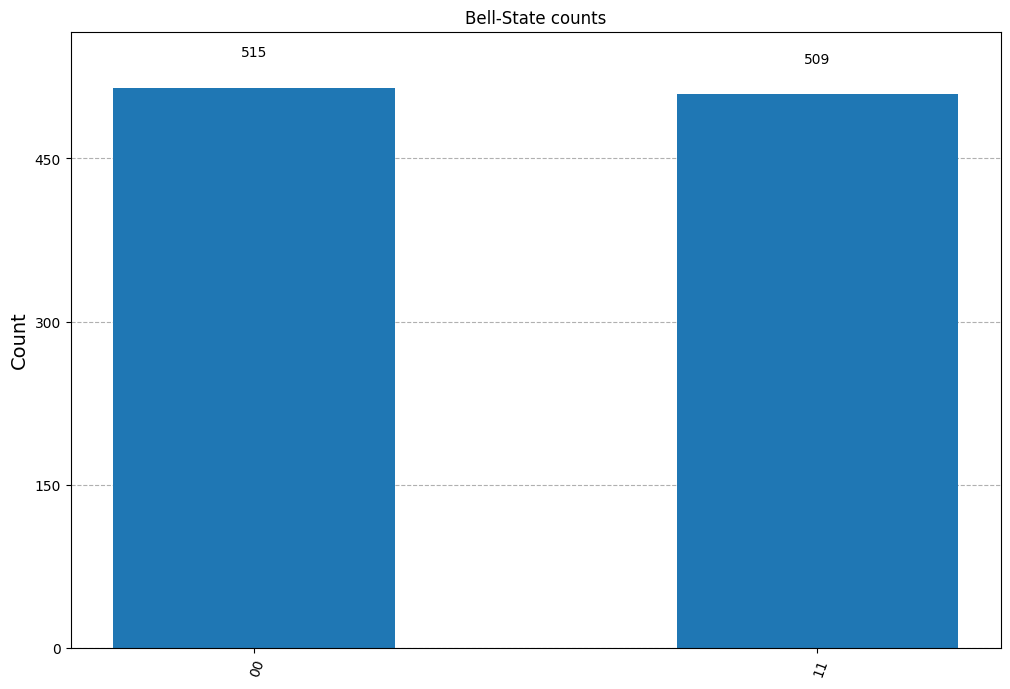

In [32]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = AerSimulator()
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [33]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
 
# create a Bell circuit
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()
 
# create two parameterized circuits
pqc = RealAmplitudes(num_qubits=2, reps=2)
pqc.measure_all()
pqc2 = RealAmplitudes(num_qubits=2, reps=3)
pqc2.measure_all()
 
theta1 = [0, 1, 1, 2, 3, 5]
theta2 = [0, 1, 2, 3, 4, 5, 6, 7]
 
# initialization of the sampler
sampler = Sampler()
 
# collect 128 shots from the Bell circuit
job = sampler.run([bell], shots=128)
job_result = job.result()
print(f"The primitive-job finished with result {job_result}")
 
# run a sampler job on the parameterized circuits
job2 = sampler.run([(pqc, theta1), (pqc2, theta2)])
job_result = job2.result()
print(f"The primitive-job finished with result {job_result}")

The primitive-job finished with result PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=128, num_bits=2>)), metadata={'shots': 128})], metadata={})
The primitive-job finished with result PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'shots': 1024}), SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'shots': 1024})], metadata={})


In [35]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
 
circuit = QuantumCircuit(2)
circuit.x(0)
circuit.x(1)
circuit.measure_all()
 
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_montreal")
 
options = Options(resilience_level = 1) # 1 = measurement error mitigation
sampler = Sampler(session=backend, options=options)
 
# Run
result = sampler.run(circuit, shots=4000).result()
quasi_dists = result.quasi_dists
 
print("Quasi dists: ", quasi_dists)

QiskitBackendNotFoundError: 'No backend matches the criteria.'

In [36]:
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler

# Step 1: Create a Quantum Circuit with 2 qubits
circuit = QuantumCircuit(2)

# Step 2: Apply X gates to both qubits
circuit.x(0)
circuit.x(1)

# Step 3: Measure all qubits
circuit.measure_all()

# Step 4: Instantiate the Sampler and run the circuit
sampler = Sampler()
result = sampler.run(circuit, shots=200).result()

# Step 5: Retrieve and print quasi-probability distributions
quasi_dists = result.quasi_dists

print("Quasi-dists: ", quasi_dists)
print("Result: ", result)


Quasi-dists:  [{3: 1.0}]
Result:  SamplerResult(quasi_dists=[{3: 1.0}], metadata=[{'shots': 200}])


In [37]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 42

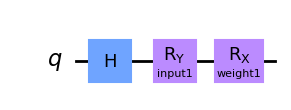

In [38]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl", style="clifford")

In [39]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

In [40]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']
weight, ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


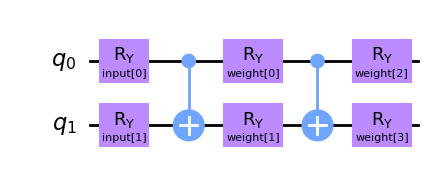

In [44]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw("mpl", style="clifford")


In [45]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2)
sampler_qnn

In [46]:
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

In [47]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

Forward pass result for SamplerQNN: [[0.01826527 0.25735654 0.5267981  0.19758009]].  
Shape: (1, 4)


In [48]:
estimator_qnn_forward = estimator_qnn.forward(estimator_qnn_input, estimator_qnn_weights)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward}. \nShape: {estimator_qnn_forward.shape}"
)

Forward pass result for EstimatorQNN: [[0.2970094]]. 
Shape: (1, 1)


In [49]:
estimator_qnn_forward_batched = estimator_qnn.forward(
    [estimator_qnn_input, estimator_qnn_input], estimator_qnn_weights
)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward_batched}.  \nShape: {estimator_qnn_forward_batched.shape}"
)

Forward pass result for EstimatorQNN: [[0.2970094]
 [0.2970094]].  
Shape: (2, 1)


In [50]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}"
)

Forward pass result for SamplerQNN: [[0.01826527 0.25735654 0.5267981  0.19758009]
 [0.01826527 0.25735654 0.5267981  0.19758009]].  
Shape: (2, 4)


In [52]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

In [53]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]].  
Shape: (1, 4, 4)


In [54]:
estimator_qnn.input_gradients = True
sampler_qnn.input_gradients = True

In [55]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

Input gradients for EstimatorQNN: [[[0.3038852]]].  
Shape: (1, 1, 1)
Weight gradients for EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


In [56]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: [[[-0.05844702 -0.10621091]
  [ 0.38798796 -0.19544083]
  [-0.34561132  0.09459601]
  [ 0.01607038  0.20705573]]].  
Shape: (1, 4, 2)
Weight gradients for SamplerQNN: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]].  
Shape: (1, 4, 4)


In [58]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

In [59]:
estimator_qnn_forward2 = estimator_qnn2.forward(estimator_qnn_input, estimator_qnn_weights)
estimator_qnn_input_grad2, estimator_qnn_weight_grad2 = estimator_qnn2.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Forward output for EstimatorQNN1: {estimator_qnn_forward.shape}")
print(f"Forward output for EstimatorQNN2: {estimator_qnn_forward2.shape}")
print(f"Backward output for EstimatorQNN1: {estimator_qnn_weight_grad.shape}")
print(f"Backward output for EstimatorQNN2: {estimator_qnn_weight_grad2.shape}")

Forward output for EstimatorQNN1: (1, 1)
Forward output for EstimatorQNN2: (1, 2)
Backward output for EstimatorQNN1: (1, 1, 1)
Backward output for EstimatorQNN2: (1, 2, 1)


In [60]:
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=output_shape,
)

In [61]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 4)
Backward output for SamplerQNN2: (1, 2, 4)


In [66]:
from classical_to_quantum.applications.graph.cliquep import CliqueP
from classical_to_quantum.applications.graph.graph_problem import Graph

vc = CliqueP(file_path="/USERS/mac/workspace/quantum-journey2/classical_to_quantum/graph_cases/Gset/G1")
vc.run(verbose=True)
vc.show_results()
vc.plot_res()


TypeError: run() got an unexpected keyword argument 'verbose'

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

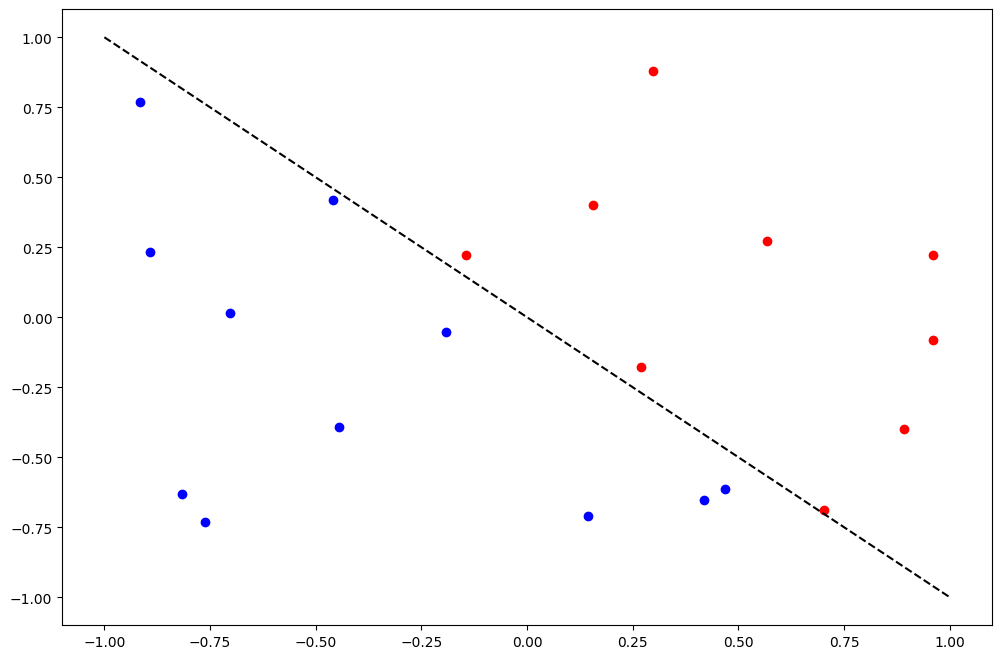

In [79]:
n_inputs = 2
n_samples = 20

X = 2 * algorithm_globals.random.random([n_samples,n_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) > 0)
y = 2 * y01 - 1

y_one_hot = np.zeros((n_samples,2))
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0],x[1],'ro')
    else:
        plt.plot(x[0],x[1],'bo')
plt.plot([-1,1],[1,-1],"--", color='black')

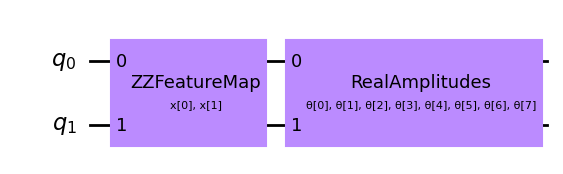

In [80]:
qc = QNNCircuit(num_qubits=n_inputs)
qc.draw("mpl", style="clifford")

In [83]:
estimator_qnn = EstimatorQNN(circuit=qc)
estimator_qnn.forward(X[0,:],algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.18452335]])

In [88]:

#objective_func_vals = []
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [89]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

0.7

In [93]:
y_predicted = estimator_classifier.predict(X)

for x, y_target, y_p in zip(X, y, y_predicted):
    if y_target == 1:
        plt.plot(x[0],x[1],'ro')
    else:
        plt.plot(x[0],x[1],'bo')
    if y_target != y_p:
        plt.scatter(x[0],x[1],s=200,facecolors='none',edgecolors='r',linewidths=1)
plt.plot([-1,1],[1,-1])

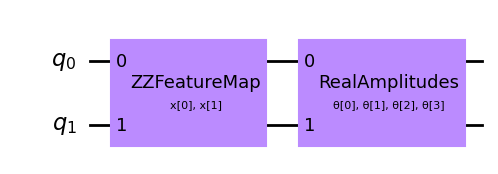

In [94]:
qc = QNNCircuit(ansatz=RealAmplitudes(2, reps=1))
qc.draw("mpl", style="clifford")

In [98]:
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2

In [100]:
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph,
)

In [101]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

0.7

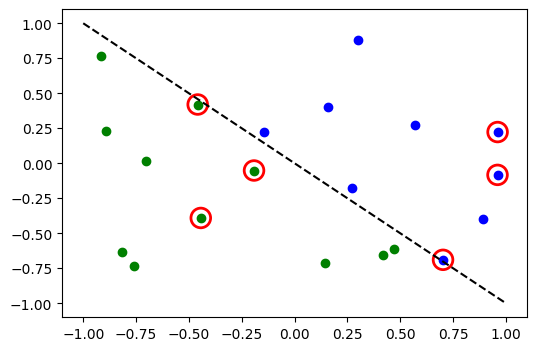

In [102]:
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


In [103]:
feature_map = ZZFeatureMap(n_inputs)
ansatz = RealAmplitudes(n_inputs, reps=1)

vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          loss="cross_entropy",
          optimizer=COBYLA(maxiter=60),
          callback=callback_graph)


In [107]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y)

0.65

In [110]:
print(y_one_hot)
print(y)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[ 1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1  1  1 -1 -1 -1 -1  1  1]


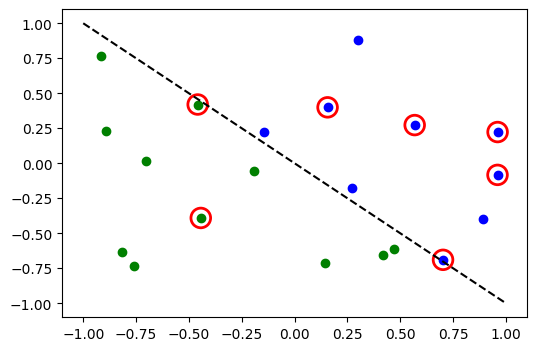

In [113]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [115]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

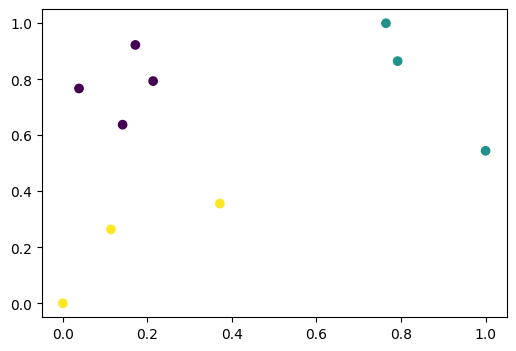

In [117]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [119]:
y.shape

(10,)

In [124]:
y_cat = np.empty(y.shape, dtype=str)
print(y_cat)
print(y==0)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['' '' '' '' '' '' '' '' '' '']
[ True  True False False False  True False False  True False]
['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


In [125]:
vqc = VQC(
    num_qubits=n_inputs,
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph,
)



In [126]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_cat)

0.9

In [127]:
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'A']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


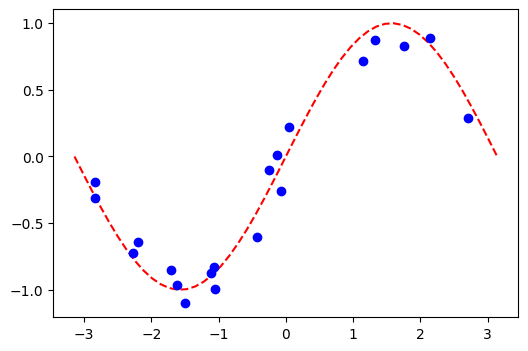

In [140]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_  = np.linspace(lb, ub, num = 50).reshape(50 ,1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:,0]) + eps * (2*algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()






In [146]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
qc.draw("mpl")

# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)

In [148]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

In [149]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

0.9622993525162624

In [157]:
from sklearn.datasets import load_iris
iris_data = load_iris()
print(iris_data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [159]:
features = iris_data.data
labels = iris_data.target

In [167]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

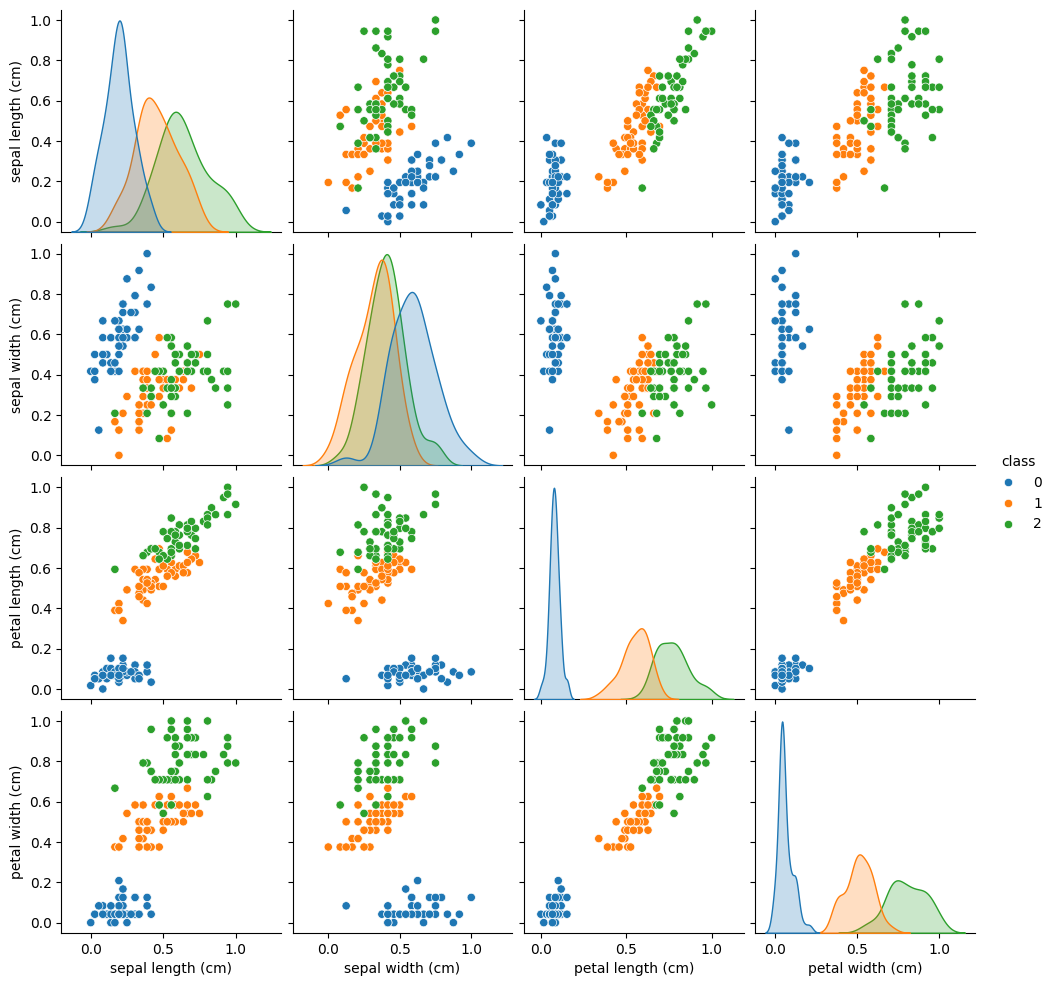

In [176]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=features, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)
sns.pairplot(df, hue="class", palette="tab10")

In [178]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [180]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)

In [182]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     1.00


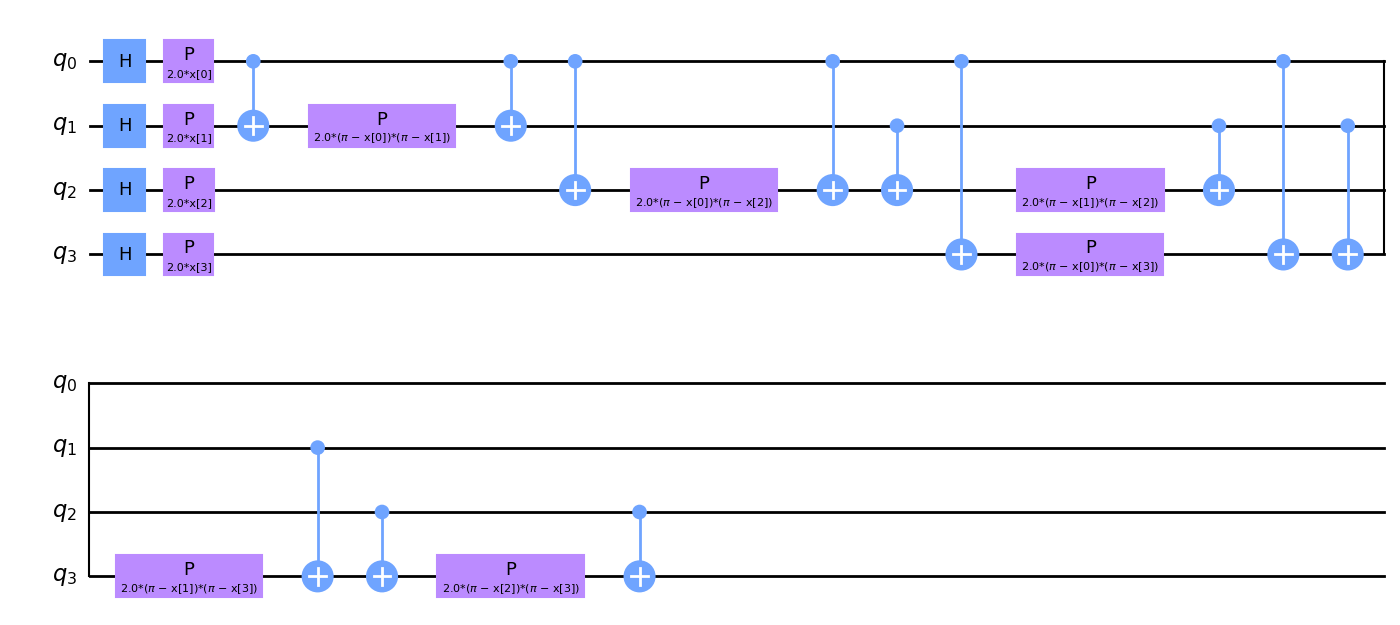

In [215]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw("mpl",style="clifford",fold=20)

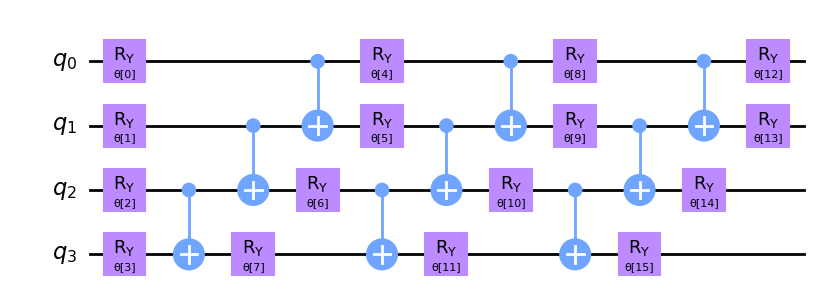

In [216]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [219]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=60)

from qiskit.primitives import Sampler
sampler = Sampler()

In [228]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, objective_func_val):
    clear_output(wait=True)
    objective_func_vals.append(objective_func_val)
    plt.plot(range(len(objective_func_vals), objective_func_vals))
    plt.show()
    


In [231]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [222]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

QiskitMachineLearningError: 'The model has not been fitted yet'

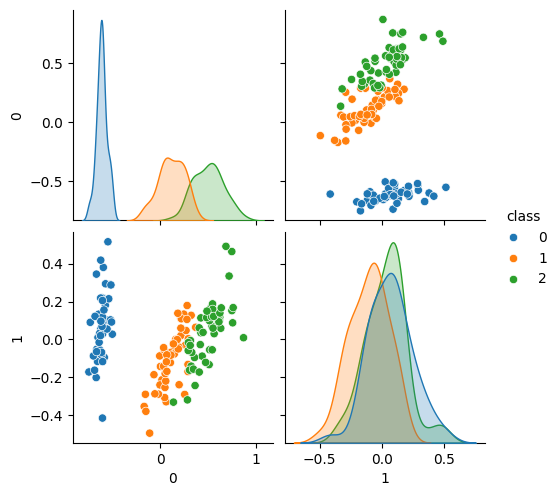

In [236]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)
sns.scatterplot(x=features[:,0], y =features[:,1], hue=labels, palette="tab10")
df_new = pd.DataFrame(data=features)
df_new["class"] = pd.Series(iris_data.target)
sns.pairplot(df_new, hue="class", palette="tab10")

In [237]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


In [240]:
svc.fit(train_features, train_labels)

SVC()

In [241]:
train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.95
Classical SVC on the test dataset:     1.00


In [242]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=60)

In [244]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [245]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

QiskitMachineLearningError: 'The model has not been fitted yet'